In [1]:
import math
import sys
import os

import IPython
import matplotlib.pylab as plt
import numpy as np
from scipy import signal

%load_ext autoreload
%autoreload 2

In [2]:
from crazyflie_description_py.parameters import N_BUFFER, FS
from audio_stack.parameters import TUKEY_ALPHA

tukey_window = signal.tukey(N_BUFFER, alpha=TUKEY_ALPHA)
hann_window = signal.hann(N_BUFFER)
flattop_window = signal.flattop(N_BUFFER, True)

hann correction factor: 4.99995e-01
tukey correction factor: 8.99991e-01
flattop correction factor: 2.15577e-01
hann correction factor: 4.99951e-01
tukey correction factor: 8.99912e-01
flattop correction factor: 2.15558e-01
hann correction factor: 4.99512e-01
tukey correction factor: 8.99121e-01
flattop correction factor: 2.15368e-01


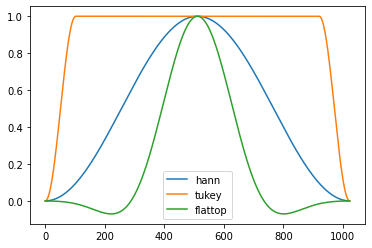

In [3]:
plt.plot(hann_window, label="hann")
plt.plot(tukey_window, label="tukey")
plt.plot(flattop_window, label="flattop")
plt.legend()

for n_buffer in [N_BUFFER*100, N_BUFFER*10, N_BUFFER]: #N_BUFFER*1000, N_BUFFER*10000]:
    tukey = signal.tukey(n_buffer, alpha=TUKEY_ALPHA)
    hann = signal.hann(n_buffer)
    flattop = signal.flattop(n_buffer, True)
    for label, window in zip(["hann", "tukey", "flattop"],[hann, tukey, flattop]):
        corr_factor = np.sum(window)/n_buffer
        print(f'{label} correction factor: {corr_factor:.5e}')

In [ ]:
from audio_stack.parameters import WINDOW_CORRECTION
fs = [1000, 1200, 2000]
noise = 1e-4
s = np.random.normal(scale=noise, size=N_BUFFER)
for f in fs:
    s += np.sin(2*np.pi*f*np.arange(N_BUFFER)/FS)
    plt.axvline(f, color='k', ls=':')
plt.axvline(f, color='k', ls=':', label='source frequencies')

freq = np.fft.rfftfreq(N_BUFFER, 1/FS)
for label, window in zip(['None', 'hann', 'tukey', 'flattop'], [None, hann_window, tukey_window, flattop_window]):
    if window is not None:
        mag = np.abs(np.fft.rfft(s*window))/WINDOW_CORRECTION[label]
    else:
        mag = np.abs(np.fft.rfft(s))
    plt.semilogy(freq, mag/N_BUFFER, label=label) 
plt.xlim(max(min(fs)-500, 0), max(fs)+500)
plt.legend(loc='lower right')

In [ ]:
out_dir = "../firmware/audio_shield_firmware/Core/Inc"

save_dict = {
    "hann_window": hann_window,
    "tukey_window": tukey_window,
    "flattop_window": flattop_window,
}

max_int16 = 2**(16-1) - 1
print(max_int16)


for key, arr in save_dict.items():
    arr = np.copy(arr)
    assert np.all(arr <= 1.0), arr[arr > 1.0]
    assert np.all(arr >= -1.0)
    print(np.min(arr), np.max(arr))
    
    arr *= max_int16 
    arr = np.round(arr)
    print(arr)
    
    fname = f"{out_dir}/{key}.h"
    with open(fname, "w+") as f:
        f.write(f"#ifndef __{key.upper()}_H \n#define __{key.upper()}_H\n\n")

        f.write(f"int16_t {key}[{N_BUFFER}] = " + r"{")
        [f.write(f"{s:.0f}, ",) for s in arr[:-1]]
        [f.write(f"{s:.0f}",) for s in arr[-1:]]
        f.write(r"};" + " \n\n")

        f.write(f"#endif /* __{key.upper()}_H */")
    print('wrote to', fname)